# Model Construction and Hyperparameter Tuning

In [1]:
#import relevant packages
import numpy as np
import pandas as pd
import similarity as sm
import matplotlib.pyplot as plt
import imp
imp.reload(sm)

<module 'similarity' from '/notebooks/similarity.py'>

In [2]:
#import data
article_data = pd.read_pickle('ArXiv/articles.pkl')
author_data = pd.read_pickle('ArXiv/authors.pkl')

## Preprocessing Text Data

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = 'english', max_df = .9)

In [4]:
corpus = list(article_data.abstract)

In [5]:
text_vectorized = vectorizer.fit_transform(corpus)

In [6]:
text_vectorized.shape

(1753039, 567327)

Here we attempt to fit a vectorizer to the entire dataset. This will be used to find similar articles by text similarity only. Although the Doc2Vec vectorizer better necodes semantic meaning and therefore produces a better similarity metric, is too computationally expensive to use on the entire dataset. Therefore the vectorizer will allow us to get a rough similarity metric. We will then use Doc2Vec on the most similar subset of these articles to get a more precise similarity metric and produce the actual results of the search.

To visualize the effectiveness of the Tfidf Vector at encoding semantic meaning, we will reduce the vectors to 2 components and plot with color determined by category.

## Visualizing Text Data

In [7]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 2)

In [8]:
text_2d = svd.fit_transform(text_vectorized)

In [9]:
text_2d.shape

(1753039, 2)

In [10]:
categories_new = [categories.split() for categories in article_data.categories]

In [11]:
categories_num = [len(categories) for categories in categories_new]

In [12]:
article_data['x'] = text_2d[:,0]
article_data['y'] = text_2d[:,1]
article_data['categories_new'] = categories_new
article_data['categories_num'] = categories_num

In [13]:
categories_set = list(set([category for categories in article_data.categories_new for category in categories]))
print(len(categories_set))

176


Because there are 176 categories, we will not be able to effectively visualize the distribution of different categories all at once. Further, many articles belong to several categories which would make simultaneous visualization even more complicated. Therefore, we will select a sample of categories to visualize seperately. We may have to simplify things further by taking a sample of the articles as well since it may be hard to distinguish millions of points on a 2d graph.

In [14]:
import random
random.seed(42)
to_plot = random.sample(categories_set, 36)
to_plot

['cs.CY',
 'econ.EM',
 'cs.NE',
 'math.GN',
 'cs.DS',
 'nlin.SI',
 'math.OC',
 'cs.FL',
 'acc-phys',
 'nucl-th',
 'cond-mat.quant-gas',
 'q-fin.GN',
 'math.GM',
 'math.QA',
 'q-alg',
 'physics.med-ph',
 'atom-ph',
 'math.SP',
 'eess.SY',
 'cs.OS',
 'cond-mat.soft',
 'cs.SE',
 'astro-ph.IM',
 'cs.IR',
 'math.AG',
 'cond-mat.stat-mech',
 'physics.ins-det',
 'q-bio.CB',
 'econ.GN',
 'cmp-lg',
 'cs.CL',
 'math.NT',
 'nlin.AO',
 'stat.OT',
 'eess.AS',
 'cond-mat.other']

In [15]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std, **kwargs):
    
    cov = np.cov(x,y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    
    rad_x = np.sqrt(1 + pearson)
    rad_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0,0), width = 2*rad_x, height = 2*rad_y, facecolor = 'none', **kwargs)
    
    scale_x = np.std(x)*n_std
    x_bar = np.mean(x)
    
    scale_y = np.std(y)*n_std
    y_bar = np.mean(y)
    
    transform = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(x_bar, y_bar)
    
    ellipse.set_transform(transform + ax.transData)
    
    return ax.add_patch(ellipse)

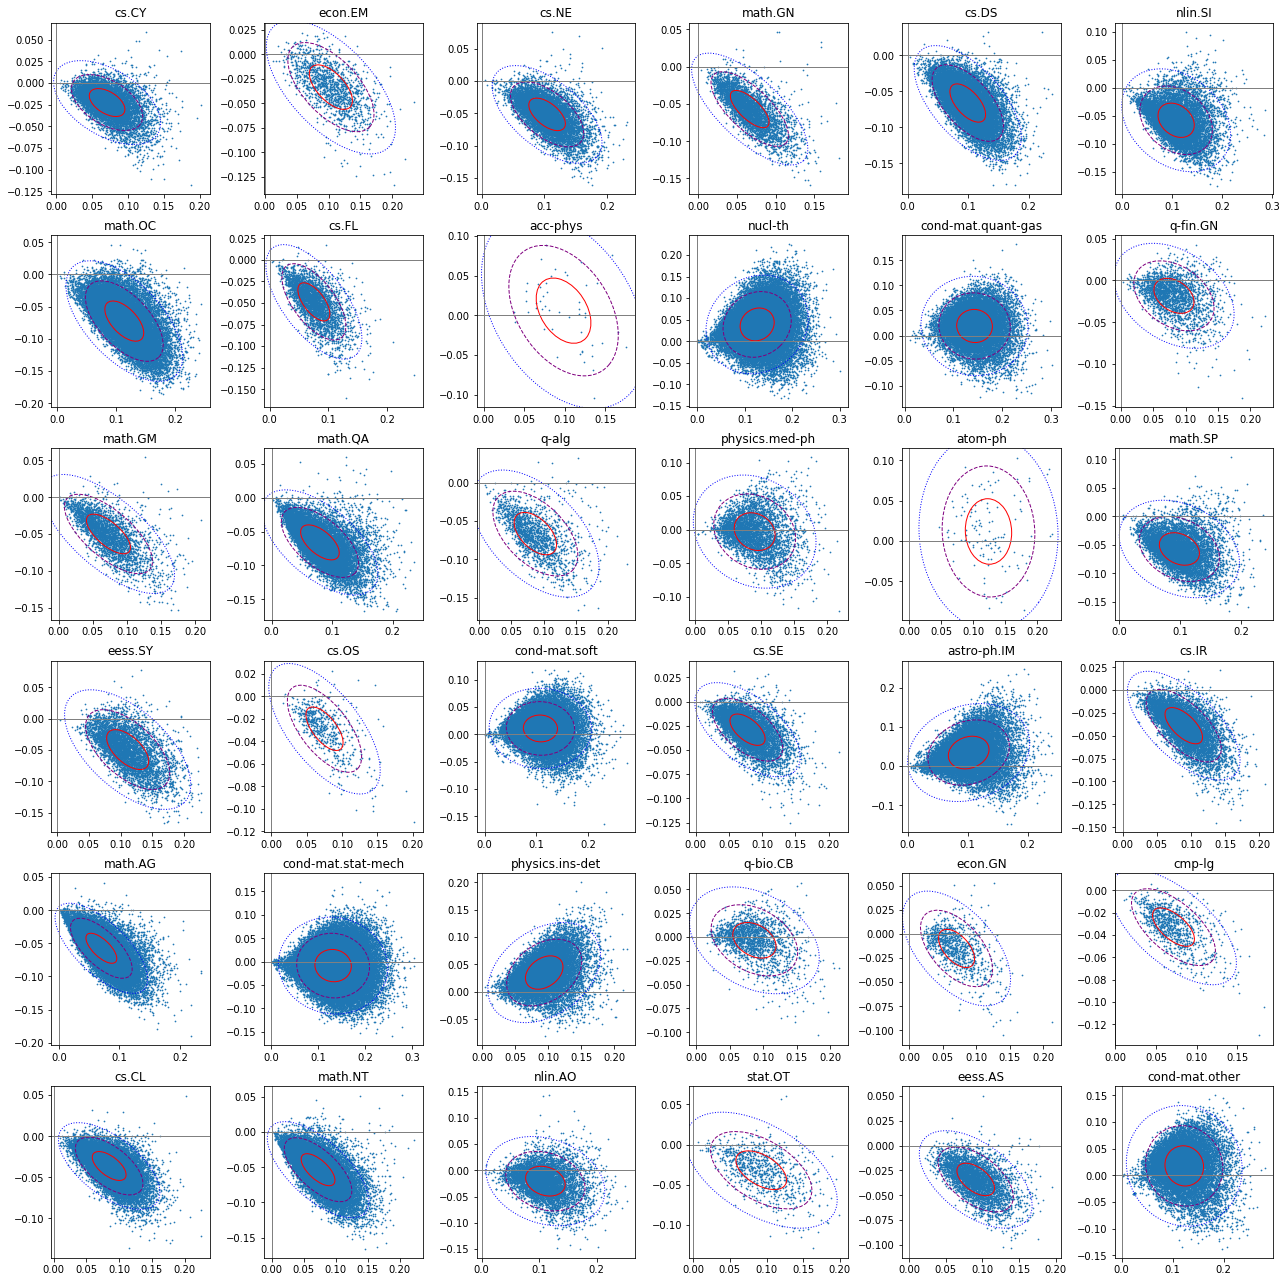

In [16]:
fig, axs = plt.subplots(6, 6, figsize = (18, 18))
fig.tight_layout(pad = 2)
for ax, category in zip(np.ndarray.flatten(axs), to_plot):
    of_interest = [category in categories for categories in article_data.categories_new]
    x = article_data[of_interest].x
    y = article_data[of_interest].y
    
    ax.scatter(x, y, s = 0.5)
    ax.axvline(c = 'grey', lw = 1)
    ax.axhline(c = 'grey', lw = 1)
    confidence_ellipse(x, y, ax, 1, edgecolor = 'red')
    confidence_ellipse(x, y, ax, 2, edgecolor = 'purple', linestyle = '--')
    confidence_ellipse(x, y, ax, 3, edgecolor = 'blue', linestyle = ':')
    
    ax.set_title(category)

There are several interesting observations to be made from the above graphs. Firstly, the different categories are surprisingly well differentiated considering the fact that we reduced a 500,000 dimensional representation down to 2 dimensions. The categories have varying means and distributions, suggesting that some semantic meaning is certainly encoded by the vector representation. Further, articles of the same parent category appear to have distributions which are more alike to each other than they are to articles of another parent category. This provides further encouragement. We also see that the data is densely distributed by category rather than spread out. This suggests that the categories are in fact good indicators of the content of an article. Lastly, one interesting observation is that nearly all of the distributions display negative correlation except for a few physics based categories, which display positive correlations. This indicates that the terminology used in these papers is highly different from the terminology found in most other types of papers samples.

We will now get a better idea of the effectiveness of our vectorization by finding similar articles for a few test cases.

## Tfidf Similarity Functions

In [17]:
def cosine_similarity(from_ids, text_vectorized):
    
    N = len(article_data)
    M = len(from_ids)
    similarity_array = np.empty((N,M))

    for i in range(M):
        
        index = list(article_data[article_data.id == from_ids[i]].index)[0]
    
        similarity = np.dot(text_vectorized, text_vectorized[index].T)
        similarity = similarity.todense()
        similarity += 1
        similarity_array[:, i] = np.squeeze(similarity)
    
    similarity_score = M / np.sum(1/similarity_array, axis = 1)
    similarity_score += -1
    
    return similarity_score

In [18]:
def text_only_similarity(from_ids, text_vectorized):
    
    df = pd.DataFrame()
    df['id'] = article_data['id']
    df['similarity_score'] = cosine_similarity(from_ids, text_vectorized)
    df.sort_values(by = 'similarity_score', ascending = False, inplace = True)
    
    return df

## Test Similarity

In [19]:
article_data[article_data.id == '0704.0002']

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,...,versions,update_date,authors_parsed,num_authors,authors_new,abstract_length,x,y,categories_new,categories_num
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]",2,"[streinuileana, theranlouis]",107,0.076638,-0.070734,"[math.CO, cs.CG]",2


In [20]:
list(article_data[article_data.id == '0704.0002'].abstract)[0]

'  We describe a new algorithm, the $(k,\\ell)$-pebble game with colors, and use\nit obtain a characterization of the family of $(k,\\ell)$-sparse graphs and\nalgorithmic solutions to a family of problems concerning tree decompositions of\ngraphs. Special instances of sparse graphs appear in rigidity theory and have\nreceived increased attention in recent years. In particular, our colored\npebbles generalize and strengthen the previous results of Lee and Streinu and\ngive a new proof of the Tutte-Nash-Williams characterization of arboricity. We\nalso present a new decomposition that certifies sparsity based on the\n$(k,\\ell)$-pebble game with colors. Our work also exposes connections between\npebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and\nWestermann and Hendrickson.\n'

We will start by finding textually similar articles to the one above based on the abstract. This article has been selected because it contains a very specific vocabulary ('sparsity', 'rigidity', 'pebble-games', etc). Therefore, similar articles ought to deal with these topics as well, so it will be easier to evaluate how our similarity function performs.

In [22]:
df = text_only_similarity(['0704.0002'], text_vectorized)

In [23]:
df.head(10)

,id,similarity_score
1,0704.0002,1.000000
1684096,math/0703921,0.408606
1682407,math/0702129,0.355321
1685145,math/9508218,0.337655
858390,1706.03655,0.331235
871375,1707.06343,0.319749
724677,1604.05510,0.312713
996212,1806.10572,0.293841
547841,1408.2535,0.289954
1477975,cond-mat/0702635,0.289470


Of course the target article will have the highest similarity with itself. So, discounting the top entry we will now examine the abstracts of the next most similar articles and determine relevance. 

In [24]:
for ID in df.head(10).id[1:]:
    print('ID: ', ID)
    print('Authors: ', list(article_data[article_data.id == ID].authors)[0])
    print()
    print('Abstract: ')
    print(list(article_data[article_data.id == ID].abstract)[0])
    print()
    print('--------------------')
    print()

ID:  math/0703921
Authors:  Ileana Streinu and Louis Theran

Abstract: 
  A hypergraph $G=(V,E)$ is $(k,\ell)$-sparse if no subset $V'\subset V$ spans
more than $k|V'|-\ell$ hyperedges. We characterize $(k,\ell)$-sparse
hypergraphs in terms of graph theoretic, matroidal and algorithmic properties.
We extend several well-known theorems of Haas, Lov{\'{a}}sz, Nash-Williams,
Tutte, and White and Whiteley, linking arboricity of graphs to certain counts
on the number of edges. We also address the problem of finding
lower-dimensional representations of sparse hypergraphs, and identify a
critical behaviour in terms of the sparsity parameters $k$ and $\ell$. Our
constructions extend the pebble games of Lee and Streinu from graphs to
hypergraphs.


--------------------

ID:  math/0702129
Authors:  Audrey Lee and Ileana Streinu

Abstract: 
  A multi-graph $G$ on $n$ vertices is $(k,\ell)$-sparse if every subset of
$n'\leq n$ vertices spans at most $kn'- \ell$ edges. $G$ is {\em tight} if, in
add

A few interesting observations may be made from the above data. We see that the first 2 articles are extremely similar. In fact, the first article shares both authors with the original article, and the second article shares one author and is referenced in the original abstract. While this may be encouraging for the validity of our similarity function, the remaining articles are less relevant. Some deal with pebble-game algorithms from a computer sicence perspective, which may be relevant, but many deal with astronomy and planet formation. It becomes clear that the common factor among all these articles is the word 'pebble'. Presumably because 'pebble' does not frequently appear in the corpus of all articles, it is given outsized importance by our similarity function. Therefore, while the function is certainly useful for roughly approximating similarity, we will have to use Doc2Vec to get a better selection of similar articles. To do this we will take the top n (hyperparameter to be tuned) articles given by the Tfidf similarity function, and perform Doc2Vec vectorization. This will hopefully encode more semantic meaning than Tfidf and so by calculating cosine similarity we will achieve a more meaningful similarity metric.

## Doc2Vec Similarity

In [25]:
from_ids = ['0704.0002']
to_ids = list(df[~df['id'].isin(from_ids)].head(500).id)

In [26]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
import string

def tokenize(text):
    
    stem = nltk.stem.SnowballStemmer('english')
    text = text.lower()
    
    for token in text.split():
        if token in string.punctuation:
            continue
        yield stem.stem(token)


def doc2vec(from_ids, to_ids):
    
    ids = from_ids + to_ids
    L = len(ids)
    
    corpus = list(article_data[article_data['id'].isin(ids)].abstract)
    corpus = [list(tokenize(abstract)) for abstract in corpus]
    corpus = [TaggedDocument(words, [i]) for i, words in enumerate(corpus)]
    
    model = Doc2Vec(corpus, min_count = 1)
    
    base = [model[i] for i in range(len(from_ids))]
    
    model_normed = [model[i]/np.sqrt(sum(model[i]**2)) for i in range(L)]
    
    base_normed = [vec/np.sqrt(sum(vec**2)) for vec in base]
    
    scores = np.array([[np.dot(base_vec, model_vec) for model_vec in model_normed] for base_vec in base_normed])
    
    scores = scores.shape[0]/np.sum(1/scores, axis = 0)
    
    return base_normed, model_normed, scores

In [27]:
base_normed, model_normed, scores = doc2vec(from_ids, to_ids)

In [28]:
new_df = pd.DataFrame()
new_df['id'] = df[df['id'].isin(from_ids + to_ids)].id
new_df['Tfidf_score'] = df[df['id'].isin(from_ids + to_ids)].similarity_score
new_df['doc2vec_score'] = scores
new_df['diff'] = new_df.doc2vec_score - new_df.Tfidf_score

In [29]:
new_df.head(10)

,id,Tfidf_score,doc2vec_score,diff
1,0704.0002,1.000000,1.000000,1.192093e-07
1684096,math/0703921,0.408606,0.995805,5.871993e-01
1682407,math/0702129,0.355321,0.995283,6.399613e-01
1685145,math/9508218,0.337655,0.994662,6.570070e-01
858390,1706.03655,0.331235,0.976806,6.455710e-01
871375,1707.06343,0.319749,0.986087,6.663380e-01
724677,1604.05510,0.312713,0.995622,6.829094e-01
996212,1806.10572,0.293841,0.996795,7.029540e-01
547841,1408.2535,0.289954,0.996437,7.064824e-01
1477975,cond-mat/0702635,0.289470,0.996306,7.068361e-01


In [30]:
new_df.sort_values(by = 'doc2vec_score', ascending = False, inplace = True)

In [31]:
new_df.head(10)

,id,Tfidf_score,doc2vec_score,diff
1,0704.0002,1.000000,1.000000,1.192093e-07
1049093,1811.04460,0.199254,0.997084,7.978295e-01
372998,1209.5834,0.176981,0.997080,8.200982e-01
715733,1603.06312,0.172533,0.997079,8.245462e-01
923849,1712.05250,0.185546,0.997076,8.115300e-01
545791,1408.0485,0.174175,0.997068,8.228927e-01
367633,1209.0469,0.199567,0.997067,7.974999e-01
418128,1303.6471,0.172219,0.997060,8.248410e-01
1580194,hep-ph/9612257,0.223953,0.997056,7.731037e-01
1198168,1910.14249,0.187628,0.997050,8.094223e-01


In [32]:
for ID in new_df.head(10).id[1:]:
    print('ID: ', ID)
    print('Authors: ', list(article_data[article_data.id == ID].authors)[0])
    print()
    print('Abstract: ')
    print(list(article_data[article_data.id == ID].abstract)[0])
    print()
    print('--------------------')
    print()

ID:  1811.04460
Authors:  Madeleine S. Kotzagiannidis, Mike E. Davies

Abstract: 
  In this work, we present a theoretical study of signals with sparse
representations in the vertex domain of a graph, which is primarily motivated
by the discrepancy arising from respectively adopting a synthesis and analysis
view of the graph Laplacian matrix. Sparsity on graphs and, in particular, the
characterization of the subspaces of signals which are sparse with respect to
the connectivity of the graph, as induced by analysis with a suitable graph
operator, remains in general an opaque concept which we aim to elucidate. By
leveraging the theory of cosparsity, we present a novel (co)sparse graph
Laplacian-based signal model and characterize the underlying (structured)
(co)sparsity, smoothness and localization of its solution subspaces on
undirected graphs, while providing more refined statements for special cases
such as circulant graphs. Ultimately, we substantiate fundamental discrepancies
betwee

Here we find a few issues with our function. Firstly, all documents appear to have exceedingly high similarity, only being differetiated at the thousandths place. Clearly this is not a precise metric as extremely small differences in cosine similarity can lead to large shifts in similarity ranking. Further, by examining the articles above, the Doc2Vec vectorizer seems to prioritize notation as many of them contain references to 'K' and 'l' in LaTeX form. 

To ammend these issues, we examine the following possible changes:
1. Using dot product rather than cosine similarity
2. Removing non alpha-numeric characters during tokenization
3. Increasing the window size of Doc2Vec

### 1. Dot Product

In [33]:
def dot_prod_doc2vec(from_ids, to_ids):
    
    ids = from_ids + to_ids
    L = len(ids)
    
    corpus = list(article_data[article_data['id'].isin(ids)].abstract)
    corpus = [list(tokenize(abstract)) for abstract in corpus]
    corpus = [TaggedDocument(words, [i]) for i, words in enumerate(corpus)]
    
    model = Doc2Vec(corpus, min_count = 1)
    
    base = [model[i] for i in range(len(from_ids))]
    
    scores = np.array([[np.dot(base_vec, model[i]) for i in range(L)] for base_vec in base])
    scores = scores.shape[0]/np.sum(1/scores, axis = 0)
    
    return base, model, scores

In [34]:
base, model, scores = dot_prod_doc2vec(from_ids, to_ids)

dot_df = pd.DataFrame()
dot_df['id'] = df[df['id'].isin(from_ids + to_ids)].id
dot_df['Tfidf_score'] = df[df['id'].isin(from_ids + to_ids)].similarity_score
dot_df['doc2vec_score'] = scores
dot_df['diff'] = new_df.doc2vec_score - new_df.Tfidf_score

dot_df.head(10)

,id,Tfidf_score,doc2vec_score,diff
1,0704.0002,1.000000,0.191124,1.192093e-07
1684096,math/0703921,0.408606,0.342080,5.871993e-01
1682407,math/0702129,0.355321,0.253540,6.399613e-01
1685145,math/9508218,0.337655,0.198631,6.570070e-01
858390,1706.03655,0.331235,0.164622,6.455710e-01
871375,1707.06343,0.319749,0.187286,6.663380e-01
724677,1604.05510,0.312713,0.129493,6.829094e-01
996212,1806.10572,0.293841,0.444973,7.029540e-01
547841,1408.2535,0.289954,0.518358,7.064824e-01
1477975,cond-mat/0702635,0.289470,0.533681,7.068361e-01


In [35]:
dot_df.sort_values(by = 'doc2vec_score', ascending = False, inplace = True)

dot_df.head(10)

,id,Tfidf_score,doc2vec_score,diff
317639,1201.5652,0.177767,1.537080,0.818995
112863,0903.1744,0.237950,1.428374,0.758951
686852,1512.04200,0.245284,1.398701,0.751753
1097642,1903.05256,0.184000,1.309626,0.812913
674205,1511.01025,0.172465,1.299528,0.824482
1529364,hep-ex/0607067,0.177768,1.288672,0.819131
1294488,2005.14693,0.185102,1.237361,0.811733
1548549,hep-ph/0202228,0.173216,1.197958,0.823720
1229171,2001.03758,0.172711,1.177575,0.824203
1260607,2003.10252,0.235377,1.176034,0.761666


In [36]:
for ID in dot_df.head(10).id:
    print('ID: ', ID)
    print('Authors: ', list(article_data[article_data.id == ID].authors)[0])
    print()
    print('Abstract: ')
    print(list(article_data[article_data.id == ID].abstract)[0])
    print()
    print('--------------------')
    print()

ID:  1201.5652
Authors:  D0 Collaboration

Abstract: 
  We study the processes $p\bar{p} \rightarrow WZ \rightarrow
\ell\nu\ell^+\ell-$ and $p\bar{p} \rightarrow ZZ \rightarrow
\ell^+\ell^-\nu\bar{\nu}, where $\ell$ = $e$ or ${\mu}$. Using 8.6 fb$^{-1} of
integrated luminosity collected by the D0 experiment at the Fermilab Tevatron
collider, we measure the $WZ$ production cross section to be
4.50$^{+0.63}_{-0.66} pb which is consistent with, but slightly above a
prediction of the standard model. The ZZ cross section is measured to be 1.64
$\pm$ 0.46 pb, in agreement with a prediction of the standard model.
Combination with an earlier analysis of the $ZZ \rightarrow
\ell^+\ell^-\ell^+\ell^-$ channel yields a $ZZ$ cross section of
1.44$^{+0.35}_{-0.34}$ pb.


--------------------

ID:  0903.1744
Authors:  Agelos Georgakopoulos

Abstract: 
  Let $G$ be a graph each edge $e$ of which is given a length $\ell(e)$. This
naturally induces a distance $d_\ell(x,y)$ between any two vertices $x,y$

### 2. Alpha-Numeric Characters Only

In [37]:
import re

def alpha_tokenize(text):
    stem = nltk.stem.SnowballStemmer('english')
    text = text.lower()
    text = re.sub('[^a-z0-9]', ' ', text)
    
    for token in text.split():
        if token in string.punctuation:
            continue
        yield stem.stem(token)

In [38]:
def alpha_doc2vec(from_ids, to_ids):
    
    ids = from_ids + to_ids
    L = len(ids)
    
    corpus = list(article_data[article_data['id'].isin(ids)].abstract)
    corpus = [list(alpha_tokenize(abstract)) for abstract in corpus]
    corpus = [TaggedDocument(words, [i]) for i, words in enumerate(corpus)]
    
    model = Doc2Vec(corpus, min_count = 1)
    
    base = [model[i] for i in range(len(from_ids))]
    
    model_normed = [model[i]/np.sqrt(sum(model[i]**2)) for i in range(L)]
    
    base_normed = [vec/np.sqrt(sum(vec**2)) for vec in base]
    
    scores = np.array([[np.dot(base_vec, model_vec) for model_vec in model_normed] for base_vec in base_normed])
    
    scores = scores.shape[0]/np.sum(1/scores, axis = 0)
    
    return base_normed, model_normed, scores

In [39]:
base, model, scores = alpha_doc2vec(from_ids, to_ids)

alpha_df = pd.DataFrame()
alpha_df['id'] = df[df['id'].isin(from_ids + to_ids)].id
alpha_df['Tfidf_score'] = df[df['id'].isin(from_ids + to_ids)].similarity_score
alpha_df['doc2vec_score'] = scores
alpha_df['diff'] = alpha_df.doc2vec_score - alpha_df.Tfidf_score

alpha_df.head(10)

,id,Tfidf_score,doc2vec_score,diff
1,0704.0002,1.000000,1.000000,-1.192093e-07
1684096,math/0703921,0.408606,0.870569,4.619630e-01
1682407,math/0702129,0.355321,0.874429,5.191078e-01
1685145,math/9508218,0.337655,-0.528157,-8.658122e-01
858390,1706.03655,0.331235,0.889566,5.583310e-01
871375,1707.06343,0.319749,0.967149,6.474003e-01
724677,1604.05510,0.312713,0.858508,5.457948e-01
996212,1806.10572,0.293841,0.755908,4.620662e-01
547841,1408.2535,0.289954,0.844632,5.546782e-01
1477975,cond-mat/0702635,0.289470,0.851029,5.615596e-01


In [40]:
alpha_df.sort_values(by = 'doc2vec_score', ascending = False, inplace = True)

alpha_df.head(10)

,id,Tfidf_score,doc2vec_score,diff
1,0704.0002,1.000000,1.000000,-1.192093e-07
871375,1707.06343,0.319749,0.967149,6.474003e-01
365259,1208.4687,0.240007,0.962871,7.228641e-01
1309914,2006.15400,0.169311,0.957498,7.881875e-01
1084732,1902.03648,0.168950,0.952099,7.831488e-01
523609,1405.2701,0.175363,0.946420,7.710574e-01
424832,1304.5699,0.188488,0.939330,7.508425e-01
1547945,hep-ph/0112300,0.186955,0.939251,7.522962e-01
956283,1803.06150,0.245409,0.929702,6.842925e-01
145261,0909.2893,0.201118,0.926532,7.254138e-01


In [41]:
for ID in alpha_df.head(10).id:
    print('ID: ', ID)
    print('Authors: ', list(article_data[article_data.id == ID].authors)[0])
    print()
    print('Abstract: ')
    print(list(article_data[article_data.id == ID].abstract)[0])
    print()
    print('--------------------')
    print()

ID:  0704.0002
Authors:  Ileana Streinu and Louis Theran

Abstract: 
  We describe a new algorithm, the $(k,\ell)$-pebble game with colors, and use
it obtain a characterization of the family of $(k,\ell)$-sparse graphs and
algorithmic solutions to a family of problems concerning tree decompositions of
graphs. Special instances of sparse graphs appear in rigidity theory and have
received increased attention in recent years. In particular, our colored
pebbles generalize and strengthen the previous results of Lee and Streinu and
give a new proof of the Tutte-Nash-Williams characterization of arboricity. We
also present a new decomposition that certifies sparsity based on the
$(k,\ell)$-pebble game with colors. Our work also exposes connections between
pebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and
Westermann and Hendrickson.


--------------------

ID:  1707.06343
Authors:  Erik D. Demaine, Quanquan C. Liu

Abstract: 
  Pebble games are single-player games

### 3. Increase Window Size

In [42]:
def window_doc2vec(from_ids, to_ids):
    
    ids = from_ids + to_ids
    L = len(ids)
    
    corpus = list(article_data[article_data['id'].isin(ids)].abstract)
    corpus = [list(tokenize(abstract)) for abstract in corpus]
    corpus = [TaggedDocument(words, [i]) for i, words in enumerate(corpus)]
    
    model = Doc2Vec(corpus, min_count = 1, window = 10)
    
    base = [model[i] for i in range(len(from_ids))]
    
    model_normed = [model[i]/np.sqrt(sum(model[i]**2)) for i in range(L)]
    
    base_normed = [vec/np.sqrt(sum(vec**2)) for vec in base]
    
    scores = np.array([[np.dot(base_vec, model_vec) for model_vec in model_normed] for base_vec in base_normed])
    
    scores = scores.shape[0]/np.sum(1/scores, axis = 0)
    
    return base_normed, model_normed, scores

In [43]:
base, model, scores = window_doc2vec(from_ids, to_ids)

window_df = pd.DataFrame()
window_df['id'] = df[df['id'].isin(from_ids + to_ids)].id
window_df['Tfidf_score'] = df[df['id'].isin(from_ids + to_ids)].similarity_score
window_df['doc2vec_score'] = scores
window_df['diff'] = window_df.doc2vec_score - window_df.Tfidf_score

window_df.head(10)

,id,Tfidf_score,doc2vec_score,diff
1,0704.0002,1.000000,1.000000,0.000000
1684096,math/0703921,0.408606,0.849991,0.441385
1682407,math/0702129,0.355321,0.848645,0.493324
1685145,math/9508218,0.337655,0.852347,0.514692
858390,1706.03655,0.331235,0.791712,0.460477
871375,1707.06343,0.319749,0.832554,0.512805
724677,1604.05510,0.312713,0.853810,0.541097
996212,1806.10572,0.293841,0.857484,0.563642
547841,1408.2535,0.289954,0.852040,0.562086
1477975,cond-mat/0702635,0.289470,0.852488,0.563018


In [44]:
window_df.sort_values(by = 'doc2vec_score', ascending = False, inplace = True)

window_df.head(10)

,id,Tfidf_score,doc2vec_score,diff
1,0704.0002,1.000000,1.000000,0.000000
1179776,1909.09738,0.169874,0.862953,0.693079
136119,0907.3954,0.180751,0.860298,0.679547
555602,1409.3177,0.196454,0.859992,0.663538
391930,1212.2314,0.198359,0.859985,0.661627
681027,1511.07847,0.168533,0.859677,0.691144
1049093,1811.04460,0.199254,0.858907,0.659653
694257,1601.02229,0.234870,0.858896,0.624025
1662869,math/0411392,0.170469,0.858805,0.688336
896041,1710.00658,0.188539,0.858713,0.670174


In [45]:
for ID in window_df.head(10).id:
    print('ID: ', ID)
    print('Authors: ', list(article_data[article_data.id == ID].authors)[0])
    print()
    print('Abstract: ')
    print(list(article_data[article_data.id == ID].abstract)[0])
    print()
    print('--------------------')
    print()

ID:  0704.0002
Authors:  Ileana Streinu and Louis Theran

Abstract: 
  We describe a new algorithm, the $(k,\ell)$-pebble game with colors, and use
it obtain a characterization of the family of $(k,\ell)$-sparse graphs and
algorithmic solutions to a family of problems concerning tree decompositions of
graphs. Special instances of sparse graphs appear in rigidity theory and have
received increased attention in recent years. In particular, our colored
pebbles generalize and strengthen the previous results of Lee and Streinu and
give a new proof of the Tutte-Nash-Williams characterization of arboricity. We
also present a new decomposition that certifies sparsity based on the
$(k,\ell)$-pebble game with colors. Our work also exposes connections between
pebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and
Westermann and Hendrickson.


--------------------

ID:  1909.09738
Authors:  Philipp Moll, Veit Frick, Natascha Rauscher, Mathias Lux

Abstract: 
  The populari

### 4. The Kitchen Sink

None of these fixes produce noticably better results on their own. We will next try limiting the min frequency of word count to stop Doc2Vec from giving so much weight to uncommon words and force it to focus more on semantic meaning. We will also employ an expanded window size and alpha-tokenization.

In [46]:
def new_doc2vec(from_ids, to_ids):
    
    ids = from_ids + to_ids
    L = len(ids)
    
    corpus = list(article_data[article_data['id'].isin(ids)].abstract)
    corpus = [list(alpha_tokenize(abstract)) for abstract in corpus]
    corpus = [TaggedDocument(words, [i]) for i, words in enumerate(corpus)]
    
    model = Doc2Vec(corpus, min_count = 1000, window = 10)
    
    base = [model[i] for i in range(len(from_ids))]
    
    model_normed = [model[i]/np.sqrt(sum(model[i]**2)) for i in range(L)]
    
    base_normed = [vec/np.sqrt(sum(vec**2)) for vec in base]
    
    scores = np.array([[np.dot(base_vec, model_vec) for model_vec in model_normed] for base_vec in base_normed])
    
    scores = scores.shape[0]/np.sum(1/scores, axis = 0)
    
    return base_normed, model_normed, scores

In [47]:
base, model, scores = new_doc2vec(from_ids, to_ids)

new_df = pd.DataFrame()
new_df['id'] = df[df['id'].isin(from_ids + to_ids)].id
new_df['Tfidf_score'] = df[df['id'].isin(from_ids + to_ids)].similarity_score
new_df['doc2vec_score'] = scores
new_df['diff'] = new_df.doc2vec_score - new_df.Tfidf_score

new_df.head(10)

,id,Tfidf_score,doc2vec_score,diff
1,0704.0002,1.000000,1.000000,-1.192093e-07
1684096,math/0703921,0.408606,-0.278271,-6.868771e-01
1682407,math/0702129,0.355321,0.421146,6.582443e-02
1685145,math/9508218,0.337655,0.716900,3.792444e-01
858390,1706.03655,0.331235,0.448538,1.173028e-01
871375,1707.06343,0.319749,0.013061,-3.066881e-01
724677,1604.05510,0.312713,0.771547,4.588346e-01
996212,1806.10572,0.293841,0.440908,1.470665e-01
547841,1408.2535,0.289954,0.630459,3.405045e-01
1477975,cond-mat/0702635,0.289470,0.183987,-1.054823e-01


In [48]:
new_df.sort_values(by = 'doc2vec_score', ascending = False, inplace = True)

new_df.head(10)

,id,Tfidf_score,doc2vec_score,diff
1,0704.0002,1.000000,1.000000,-1.192093e-07
694257,1601.02229,0.234870,0.841595,6.067243e-01
1179776,1909.09738,0.169874,0.839943,6.700689e-01
896041,1710.00658,0.188539,0.837994,6.494546e-01
1015306,1808.06160,0.188066,0.831981,6.439148e-01
1260607,2003.10252,0.235377,0.829773,5.943957e-01
311410,1112.5855,0.219705,0.826575,6.068708e-01
555602,1409.3177,0.196454,0.826561,6.301074e-01
339914,1205.0913,0.222502,0.821695,5.991924e-01
1072330,1901.02783,0.192140,0.817224,6.250842e-01


In [49]:
for ID in new_df.head(10).id:
    print('ID: ', ID)
    print('Authors: ', list(article_data[article_data.id == ID].authors)[0])
    print()
    print('Abstract: ')
    print(list(article_data[article_data.id == ID].abstract)[0])
    print()
    print('--------------------')
    print()

ID:  0704.0002
Authors:  Ileana Streinu and Louis Theran

Abstract: 
  We describe a new algorithm, the $(k,\ell)$-pebble game with colors, and use
it obtain a characterization of the family of $(k,\ell)$-sparse graphs and
algorithmic solutions to a family of problems concerning tree decompositions of
graphs. Special instances of sparse graphs appear in rigidity theory and have
received increased attention in recent years. In particular, our colored
pebbles generalize and strengthen the previous results of Lee and Streinu and
give a new proof of the Tutte-Nash-Williams characterization of arboricity. We
also present a new decomposition that certifies sparsity based on the
$(k,\ell)$-pebble game with colors. Our work also exposes connections between
pebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and
Westermann and Hendrickson.


--------------------

ID:  1601.02229
Authors:  Ervin Gy\H{o}ri, Gyula Y. Katona, L\'aszl\'o F. Papp

Abstract: 
  In [C. Xue, C. Y

This last effort did not fare much better than the previous. We will next attempt to revectorize the data with a min frequency parameter.

## Starting from Square One: Min Frequency Tfidf

In [50]:
new_vectorizer = TfidfVectorizer(stop_words = 'english', max_df = .9, min_df = .001)
new_text_vectorized = new_vectorizer.fit_transform(corpus)

In [51]:
new_text_vectorized.shape

(1753039, 6361)

In [52]:
new_df = text_only_similarity(['0704.0002'], new_text_vectorized)

In [53]:
new_df.head(10)

,id,similarity_score
1,0704.0002,1.000000
1684096,math/0703921,0.471867
1682407,math/0702129,0.424917
693914,1601.01886,0.407505
1274375,2004.09605,0.398698
504760,1402.7235,0.390712
761631,1608.05169,0.389434
169745,1001.4457,0.387105
467786,1310.2783,0.380685
1072556,1901.03009,0.376615


In [54]:
for ID in new_df.head(10).id[1:]:
    print('ID: ', ID)
    print('Authors: ', list(article_data[article_data.id == ID].authors)[0])
    print()
    print('Abstract: ')
    print(list(article_data[article_data.id == ID].abstract)[0])
    print()
    print('--------------------')
    print()

ID:  math/0703921
Authors:  Ileana Streinu and Louis Theran

Abstract: 
  A hypergraph $G=(V,E)$ is $(k,\ell)$-sparse if no subset $V'\subset V$ spans
more than $k|V'|-\ell$ hyperedges. We characterize $(k,\ell)$-sparse
hypergraphs in terms of graph theoretic, matroidal and algorithmic properties.
We extend several well-known theorems of Haas, Lov{\'{a}}sz, Nash-Williams,
Tutte, and White and Whiteley, linking arboricity of graphs to certain counts
on the number of edges. We also address the problem of finding
lower-dimensional representations of sparse hypergraphs, and identify a
critical behaviour in terms of the sparsity parameters $k$ and $\ell$. Our
constructions extend the pebble games of Lee and Streinu from graphs to
hypergraphs.


--------------------

ID:  math/0702129
Authors:  Audrey Lee and Ileana Streinu

Abstract: 
  A multi-graph $G$ on $n$ vertices is $(k,\ell)$-sparse if every subset of
$n'\leq n$ vertices spans at most $kn'- \ell$ edges. $G$ is {\em tight} if, in
add

The result here is much better. All of the articles are relevent to the topic of the original article. Not only do they all deal with graph theory, but more specifically, the articles are focused on sparse graphs, graph colorings, or games on graphs, all of which were elements of the original article. We will now attemp to improve this result using Doc2Vec.

In [55]:
from_ids = ['0704.0002']
to_ids = list(new_df[~new_df['id'].isin(from_ids)].head(500).id)

In [56]:
base, model, scores = new_doc2vec(from_ids, to_ids)

doc_df = pd.DataFrame()
doc_df['id'] = new_df[new_df['id'].isin(from_ids + to_ids)].id
doc_df['Tfidf_score'] = new_df[new_df['id'].isin(from_ids + to_ids)].similarity_score
doc_df['doc2vec_score'] = scores
doc_df['diff'] = doc_df.doc2vec_score - doc_df.Tfidf_score

doc_df.head(10)

,id,Tfidf_score,doc2vec_score,diff
1,0704.0002,1.000000,1.000000,4.440892e-16
1684096,math/0703921,0.471867,-0.240969,-7.128356e-01
1682407,math/0702129,0.424917,-0.172511,-5.974280e-01
693914,1601.01886,0.407505,-0.162258,-5.697625e-01
1274375,2004.09605,0.398698,-0.112843,-5.115407e-01
504760,1402.7235,0.390712,-0.212540,-6.032519e-01
761631,1608.05169,0.389434,-0.101445,-4.908791e-01
169745,1001.4457,0.387105,0.192255,-1.948504e-01
467786,1310.2783,0.380685,-0.204142,-5.848272e-01
1072556,1901.03009,0.376615,-0.238165,-6.147800e-01


In [57]:
doc_df.sort_values(by = 'doc2vec_score', ascending = False, inplace = True)

doc_df.head(10)

,id,Tfidf_score,doc2vec_score,diff
1,0704.0002,1.000000,1.000000,4.440892e-16
981807,1805.08762,0.265537,0.255955,-9.581421e-03
654316,1508.07660,0.282543,0.240940,-4.160218e-02
231973,1012.2605,0.260308,0.228041,-3.226632e-02
1081288,1902.00204,0.319507,0.226381,-9.312631e-02
556588,1409.4163,0.274489,0.217943,-5.654556e-02
821516,1702.06922,0.264786,0.213364,-5.142249e-02
473714,1311.0053,0.263035,0.207045,-5.598958e-02
1269448,2004.04678,0.316171,0.205956,-1.102154e-01
655853,1509.01214,0.284858,0.204141,-8.071736e-02


In [58]:
for ID in doc_df.head(10).id[1:]:
    print('ID: ', ID)
    print('Authors: ', list(article_data[article_data.id == ID].authors)[0])
    print()
    print('Abstract: ')
    print(list(article_data[article_data.id == ID].abstract)[0])
    print()
    print('--------------------')
    print()

ID:  1805.08762
Authors:  Vaibhav Katewa and Fabio Pasqualetti

Abstract: 
  The minimum-gain eigenvalue assignment/pole placement problem (MGEAP) is a
classical problem in LTI systems with static state feedback. In this paper, we
study the MGEAP when the state feedback has arbitrary sparsity constraints. We
formulate the sparse MGEAP problem as an equality-constrained optimization
problem and present an analytical characterization of its locally optimal
solution in terms of eigenvector matrices of the closed loop system. This
result is used to provide a geometric interpretation of the solution of the
non-sparse MGEAP, thereby providing additional insights for this classical
problem. Further, we develop an iterative projected gradient descent algorithm
to obtain local solutions for the sparse MGEAP using a parametrization based on
the Sylvester equation. We present a heuristic algorithm to compute the
projections, which also provides a novel method to solve the sparse EAP. Also,
a rela

After trying all the Doc2Vec variations on new vectorization of the articles, none of them perform nearly as well as the simple Tfidf Vectorizer. This may be because the vectorizer is able to learn from the entire corpus and creates an unabridged vector representation and therefore loses less information.

Lastly, the min_df parameter of .001 was selected arbitrarily and may benefit from tuning. At .001 or 0.1%, this means that the term must appear in at least 1700 articles to be considered relevant. This seems to be a rather high bar but it has helped avoid outsized importance being attributed to notation. Therefore we may also want to consider using a second vectorizer with no min_df rather than Doc2Vec to get a more fine tuned similarity. 

## Fine Focus Vectorizer

In [59]:
vectorizer = TfidfVectorizer(stop_words = 'english', max_df = 0.9, min_df = .001)
corpus = list(article_data.abstract)
text_vectorized = vectorizer.fit_transform(corpus)

After some trials with a single fine tuning vecotrizer wihtout much success, I created the function below. This function vectorizes the text, scores the cosine similarity with the target articles and sorts the articles by that similarity. It then takes the top 50% of the articles and repeats the process for as many iterations as you would like. I tested the function with 10 iterations below,meaning the final vecotrization is done on about 1,700 articles or 0.1% of the original data.

In [238]:
def text_similarity(from_ids, text_vectorized, steps):
    
    fine_vectorizer = TfidfVectorizer(stop_words = 'english', max_df = .9, min_df = .001)
    
    df = pd.DataFrame()
    df['id'] = article_data['id']
    df['similarity_score'] = cosine_similarity(from_ids, text_vectorized)
    df.sort_values(by = 'similarity_score', ascending = False, inplace = True)
    
    N = len(df)
    
    for s in range(steps):
        df['similarity_score_' + str(s)] = 0
        
        N = N // 2
        top_ids = list(df[~df['id'].isin(from_ids)].head(N).id)
        ids = from_ids + top_ids
        similarity_fine_array = np.empty((len(ids), len(from_ids)))
        corpus_fine = list(article_data[article_data['id'].isin(ids)].abstract)
        text_vectorized_fine = fine_vectorizer.fit_transform(corpus_fine)

        for i, from_id in enumerate(from_ids):
            from_vector = text_vectorized_fine[i]
            similarity_fine = np.dot(text_vectorized_fine, from_vector.T)
            similarity_fine = similarity_fine.todense()
            similarity_fine_array[:,i] = np.squeeze(similarity_fine)
    
        similarity_fine_array += 1
        similarity_score = similarity_fine_array.shape[1] / np.sum(1/similarity_fine_array,axis = 1)
        similarity_score += -1
        similarity_score = list(similarity_score)
    
        df.loc[df['id'].isin(ids), 'similarity_score_'+str(s)] = similarity_score
        df.sort_values(by = 'similarity_score_'+str(s), ascending = False, inplace = True)
    #df['diff'] = df['similarity_score_fine'] - df['similarity_score']
    
    return df

In [239]:
from_ids = ['0704.0002']

In [240]:
similarity_df = text_similarity(from_ids, text_vectorized, 10)

In [241]:
similarity_df.head(20)

,id,similarity_score,similarity_score_0,similarity_score_1,similarity_score_2,similarity_score_3,similarity_score_4,similarity_score_5,similarity_score_6,similarity_score_7,similarity_score_8,similarity_score_9
1,0704.0002,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1124082,1905.05646,0.034783,0.047546,0.021204,0.018716,0.020532,0.016499,0.029649,0.026887,0.025411,0.077756,0.315969
1602947,hep-th/0306067,0.033829,0.028041,0.064637,0.020029,0.016677,0.266349,0.020766,0.021317,0.018038,0.034402,0.238939
209892,1008.5135,0.014615,0.019053,0.019794,0.029655,0.055237,0.018628,0.031011,0.029153,0.017190,0.055797,0.176119
1712279,physics/0005028,0.022842,0.047642,0.019272,0.085759,0.062897,0.018312,0.016951,0.023204,0.022214,0.050660,0.164628
672481,1510.08524,0.009516,0.036339,0.021609,0.025009,0.063821,0.052799,0.047594,0.035926,0.019732,0.025482,0.160286
400777,1301.4187,0.011335,0.026033,0.019291,0.028386,0.031831,0.046932,0.023283,0.018399,0.017997,0.027287,0.155727
100443,0812.4317,0.028033,0.028391,0.024042,0.037750,0.067817,0.018752,0.027477,0.023419,0.121842,0.034028,0.149136
1712372,physics/0006037,0.021800,0.023957,0.022049,0.058171,0.087136,0.022781,0.030376,0.065516,0.034314,0.030587,0.148195
519557,1404.6504,0.025795,0.097307,0.106143,0.019833,0.016927,0.035766,0.024344,0.036574,0.042628,0.019435,0.145141


In [243]:
similarity_df.sort_values(by= 'similarity_score', ascending = False).head(10)

,id,similarity_score,similarity_score_0,similarity_score_1,similarity_score_2,similarity_score_3,similarity_score_4,similarity_score_5,similarity_score_6,similarity_score_7,similarity_score_8,similarity_score_9
1,0704.0002,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1684096,math/0703921,0.471867,0.011684,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1682407,math/0702129,0.424917,0.015417,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
693914,1601.01886,0.407505,0.029933,0.014826,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1274375,2004.09605,0.398698,0.017888,0.012902,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
504760,1402.7235,0.390712,0.020525,0.009980,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
761631,1608.05169,0.389434,0.067519,0.017134,0.015182,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169745,1001.4457,0.387105,0.012799,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
467786,1310.2783,0.380685,0.014424,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1072556,1901.03009,0.376615,0.014267,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [242]:
for ID in similarity_df.head(10).id[1:]:
    print('ID: ', ID)
    print('Authors: ', list(article_data[article_data.id == ID].authors)[0])
    print()
    print('Abstract: ')
    print(list(article_data[article_data.id == ID].abstract)[0])
    print()
    print('--------------------')
    print()

ID:  1905.05646
Authors:  Toufik Mansour, Reza Rastegar, Alexander Roitershtein

Abstract: 
  The main theme of this paper is the enumeration of the occurrence of a
pattern in words and permutations. We mainly focus on asymptotic properties of
the sequence $f_r^v(k,n),$ the number of $n$-array $k$-ary words that contain a
given pattern $v$ exactly $r$ times. In addition, we study the asymptotic
behavior of the random variable $X_n,$ the number of pattern occurrences in a
random $n$-array word. The two topics are closely related through the identity
$P(X_n=r) = $ $\frac{1}{k^n}f_r^v(k,n).$ In particular, we show that for any
$r\geq 0,$ the Stanley-Wilf sequence $\bigl(f_r^v(k,n)\bigr)^{1/n}$ converges
to a limit independent of $r,$ and determine the value of the limit. We then
obtain several limit theorems for the distribution of $X_n,$ including a CLT,
large deviation estimates, and the exact growth rate of the entropy of $X_n.$
Furthermore, we introduce a concept of weak avoidance and

None of the above articles seem to have much in common with the original. In fact, of the top 10 articles scored by the orignial Tfidf Vectorizer, only 4 were in the top 50% of the second vectorizer score, and of those four, only one made it to the third vectorizer. Clearly multiple vectorizers are not yeilding ny improvements on our results. The best results were achieved with the simple Tfidf Vectorizer on the entire dataset and therefore, afer running out of ways to improve these results, we wil use this method as our similarity function for text only similarty. The author similarity was already created during EDA, and now all that remains is to create a function which takes article IDs as the input and outputs a dataframe of articles with similarity by author and by text.